In [1]:
import numpy as np 
import pandas as pd 
from pandas import datetime
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay
import holidays

from copy import deepcopy
import time
import pandas_profiling
!pip install openpyxl
!pip install ppscore

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/kaggle/input/energo-kyiv/2017 - Исторические данные.xlsx
/kaggle/input/energo-kyiv/2016 - Исторические данные.xlsx
/kaggle/input/energo-kyiv/2015 - Исторические данные.xlsx
     |████████████████████████████████| 243 kB 419 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=e54c05fd3c5bfd6230aa659a1fe77302ce6fe19c8a49c75599cd7ca7543a8588
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
     |████████████████████████████████| 47 kB 193 kB/s eta 0:00:01
  Created wheel for ppscore: filename=ppscore-1.2.0-py2.py3-none-any.whl size=13050 sha256=b51c6156bd2b8fb65ea87cf0832ac1923283b4ea9754dcb8d1405040db3b5498
  Stored in directory: /root/.cache/pip/wheels/d2/3c/58/2ff786414b21713edc6f4fdb54fdee89ac37bca5edd1f60634
Successfully built ppscore


**1.	Выполнить анализ качества данных и исправить ошибочные данные и пропуски**

In [2]:
df2015 = pd.read_excel('/kaggle/input/energo-kyiv/2015 - Исторические данные.xlsx',
                       engine='openpyxl') 
df2016 = pd.read_excel('/kaggle/input/energo-kyiv/2016 - Исторические данные.xlsx',
                      engine='openpyxl') 
df2017 = pd.read_excel('/kaggle/input/energo-kyiv/2017 - Исторические данные.xlsx',
                      engine='openpyxl') 

#Проверка на сюрпризы в типах данных
#df2015.info()
df2016.info()
#df2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Obs          8784 non-null   int64         
 1   datetime     8784 non-null   object        
 2   date         8784 non-null   datetime64[ns]
 3   HE           8784 non-null   int64         
 4   actual_load  8760 non-null   float64       
 5   temperature  8784 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 411.9+ KB


In [3]:
df2016['temperature'] = df2016['temperature'].astype(str)
df2016['temperature'] = df2016['temperature'].map(lambda x: x.rstrip('°'))
df2016['temperature'] = df2016['temperature'].astype(int)

df = pd.concat([df2015, df2016, df2017], ignore_index=True)

df['time'] = [x[-8:] for x in df['datetime']]
df['time'] = df['time'].str.replace(r'24:00:00', '23:59:59')
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

datetime = df['date'] + ' ' + df['time']
df['datetime'] = datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])
df.drop('time', 1, inplace=True)

df

Obs            datetime       date  HE  actual_load  temperature
0         1 2015-01-01 01:00:00 2015-01-01   1    1134196.0           -6
1         2 2015-01-01 02:00:00 2015-01-01   2    1068647.0           -5
2         3 2015-01-01 03:00:00 2015-01-01   3    1000581.0           -5
3         4 2015-01-01 04:00:00 2015-01-01   4     947958.0           -5
4         5 2015-01-01 05:00:00 2015-01-01   5     905317.0           -5
...     ...                 ...        ...  ..          ...          ...
26299  8756 2017-12-31 20:00:00 2017-12-31  20    1347774.0            0
26300  8757 2017-12-31 21:00:00 2017-12-31  21    1306222.0            1
26301  8758 2017-12-31 22:00:00 2017-12-31  22    1252101.0            1
26302  8759 2017-12-31 23:00:00 2017-12-31  23    1179358.0            1
26303  8760 2017-12-31 23:59:59 2017-12-31  24    1079696.0            1

[26304 rows x 6 columns]

In [4]:
profile = pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Колонка с температурой выглядит очень интересно, минимальное значение - "-21", максимальное - "+257", чего в принципе, быть не должно, если температура измеряется в градусах по Цельсию. Рассмотрю поближе значения выше 50. Их три - 257, 55, 112. Удалить эти строки нельзя, поскольку потеряется порядочность во временных данных, но их можно заменить ближайшими значениями, которые соответствуют той же дате, с разницей в один час (вперёд или назад).

In [5]:
df[df['temperature']>50]
df[df['date'] == '2015-06-25'] #index 4212
#здесь исправим на 26, поскольку в 12 часов было +25, а в 14 уже +27
df.at[4212,'temperature']=26

df[df['date'] == '2015-12-06'] #index 8136
#Здесь очевидно, ошибка, напечатали "5" дважды, потому что дальше температура стоит "6"
#исправлю на "5"
df.at[8136,'temperature']=5

df[df['date'] == '2017-09-07'] #index 23528
df.at[23528,'temperature']=12
#Полагаю, здесь лишняя единичка, и температура должна быть 12, ибо рядом 11 и 13.

In [6]:
px.line(df, x = 'datetime', y = ['actual_load'])

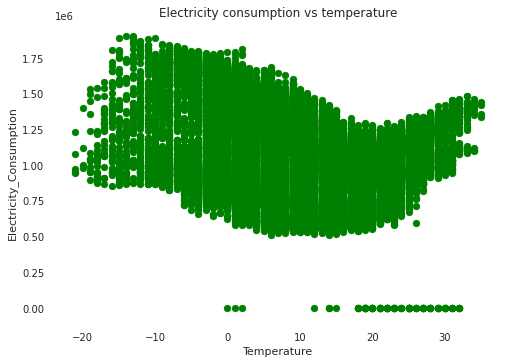

In [7]:
plt.scatter(df.temperature,df.actual_load,c='green')
plt.xlabel('Temperature')
plt.ylabel('Electricity_Consumption')
plt.title('Electricity consumption vs temperature')
plt.show()

Pandas profiling и два графика выше говорят нам о том, что в данных есть пропуски в колонке actual_load, и что либо есть ошибки в данных, когда энергопотребление равнялось нулю, либо это были аварийные отключения электричества по всему городу, ведь в веерных не отключают весь город сразу. Неважно, каковой была истинная причина, для построения модели наличие аутлаеров только повредит, ведь цель - предсказание потребления электроэнергии, а не следующее аварийное отключение. Решать эти две проблемы буду одним путем - нули превращу в отсутствующие значения, а дальше воспользуюсь автоматическим заполнением по значению предыдущей строки.

In [8]:
df.isnull().sum() #48
df.actual_load.replace(0, np.nan, inplace=True)
df.isnull().sum() #147
df.fillna(method='bfill', inplace = True)

**2. Выполнить анализ временного ряда (тренд, сезонности, стационарность)**

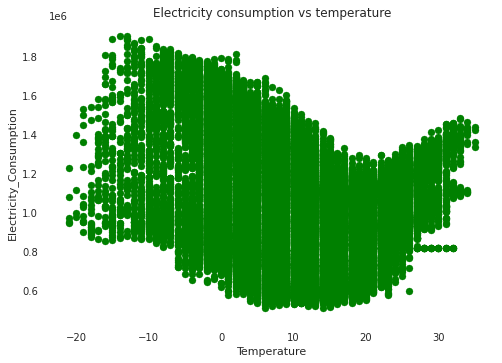

In [9]:
#проверим на том же графике как выглядят данные без пропусков и нулей
plt.scatter(df.temperature,df.actual_load,c='green')
plt.xlabel('Temperature')
plt.ylabel('Electricity_Consumption')
plt.title('Electricity consumption vs temperature')
plt.show()

Здесь четко отслеживается тренд зависимости температуры за окном и использования электронергии. Чем холоднее, тем выше поднимается диапазон значений использования электричества, причина этому очевидна - обогрев жилища. Начиная от нуля градусов и примерно до +20 диапазон очень широкий, но верхняя граница постепенно уменьшается и начинает снова расти после +20 градусов. Вместе с ней резко возрастает и нижняя граница, что свидетельствует об общем увеличении использования электроэнергии. Причина этому тоже проста - наступает жара, люди используют кондиционеры - весьма электропоглощающие приборы (хоть и на столько как обогреватели зимой).

In [10]:
px.line(df, x = 'datetime', y = ['actual_load'])

На этом обновленном графике можно заметить сезонность - в зимние месяцы расход электроэнергии растет, весной снижается, летом немного подрастает снова, в начале осени снижается, а под конец, с наступлением холодов, снова растет. Эта цикличность не удивляет. Тренда на общий рост или спад потребления электроэнергии не наблюдается, стацинарность отсутствует, поскольку есть сезонность.

In [11]:
#Как потребляется энергия в зависимости от времени суток?
px.line(df, x = 'HE', y = ['actual_load'])

Очевидно, что в ночное время, особенно с полуночи и до 6-7 утра потребление энергии резко падает, где верхняя граница составляет 1,2 М, а нижняя - менее 0,6. В дневное время нижняя граница находится в среднем на уровне 0,7 М, в то время как верхняя поднимается до 1,8 М.

In [12]:
#по номерам наблюдений в году
px.line(df, x = 'Obs', y = ['actual_load'])

В этом графике использовалась колонка с номером наблюдений, эти номера в каждом году повторяются, то есть, для 1 января они будут идти с номера 1 и до 8760 (где дата будет 31 декабря). Здесь тоже видно уже описанную выше сезонность.

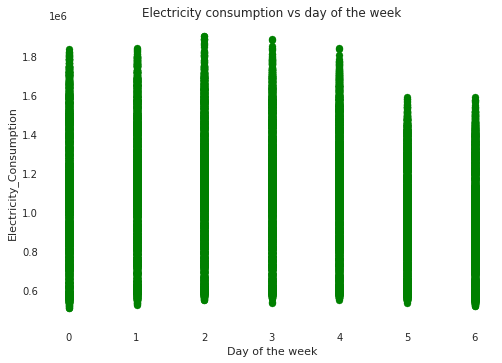

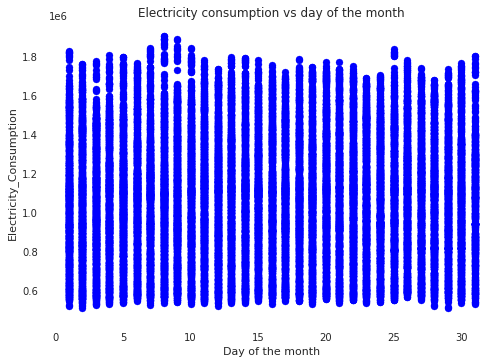

In [13]:
#день недели
df['weekday'] = df['datetime'].dt.weekday
#день месяца
df['day'] = df['datetime'].dt.day

plt.scatter(df.weekday,df.actual_load,c='green')
plt.xlabel('Day of the week')
plt.ylabel('Electricity_Consumption')
plt.title('Electricity consumption vs day of the week')
plt.show()

plt.scatter(df.day,df.actual_load,c='blue')
plt.xlabel('Day of the month')
plt.ylabel('Electricity_Consumption')
plt.title('Electricity consumption vs day of the month')
plt.show()

Выше создала две новые фичи: день недели и день месяца, чтоб посмотреть, меняется ли как-то расход энергии по этим параметрам. На графиках видно, что он меняется только в зависимости от дня недели - по выходным электроэнергии тратится меньше. Причин может быть несколько - закрытые офисы, люди выходят на улицу и меньше тратят электричества дома.

Добавлю фичу "рабочие дние" в несколько этапов. Сначала надо создать календарь с повторяемыми праздниками, где дата фиксированная. Затем создам список для выходных дней после Пасхи и Троицы (эти даты в календаре плавают). Потом создается список рабочих дат, с учетом и религиозных праздников тоже. А дальше уже конвертировать в бинарный ответ - 0 для нерабочих дней, 1 - для рабочих.

In [14]:
class calendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year", month=1, day=1, observance = nearest_workday),
        Holiday('Cristmas',month=1, day=7, observance = nearest_workday),
        Holiday('WD',month=3, day=8, observance = nearest_workday),
        Holiday('Labour Day', month=5, day=1, observance = nearest_workday),
        Holiday('Labour Day', month=5, day=2, observance = nearest_workday),
        Holiday("Victory Day",month=5, day=9, observance = nearest_workday),
        Holiday("Constitution Day",month=6, day=28, observance = nearest_workday),
        Holiday('Independence Day',month=8, day=24, observance = nearest_workday),
        Holiday('14 of October',month=10, day=14, observance = nearest_workday) 
   ]
    
holidays_UKR = holidays.UA()
ua_holidays = []
for date in sorted(holidays.UA(years=[2015,2016,2017]).items()):
    ua_holidays.append(str(date[0]))
    
#добавляю те выходные, которые не попали в календарь, поскольку даты меняются - Пасха и Троица
religious= ['2015-04-13','2015-06-01','2016-06-20', '2017-06-17','2017-06-05']

myday = CustomBusinessDay(calendar = calendar())
work_days = pd.date_range('01/01/2015', '01/01/2018', freq=myday)
work_days = [str(i).split()[0] for i in work_days]
work_days = [i for i in work_days if i not in ua_holidays and i not in religious]
len(work_days)

working = [1 if str(val).split()[0] in work_days else 0 for val in df['datetime']]
df['working_day'] = working

<AxesSubplot:title={'center':'PPS matrix'}, xlabel='feature', ylabel='target'>

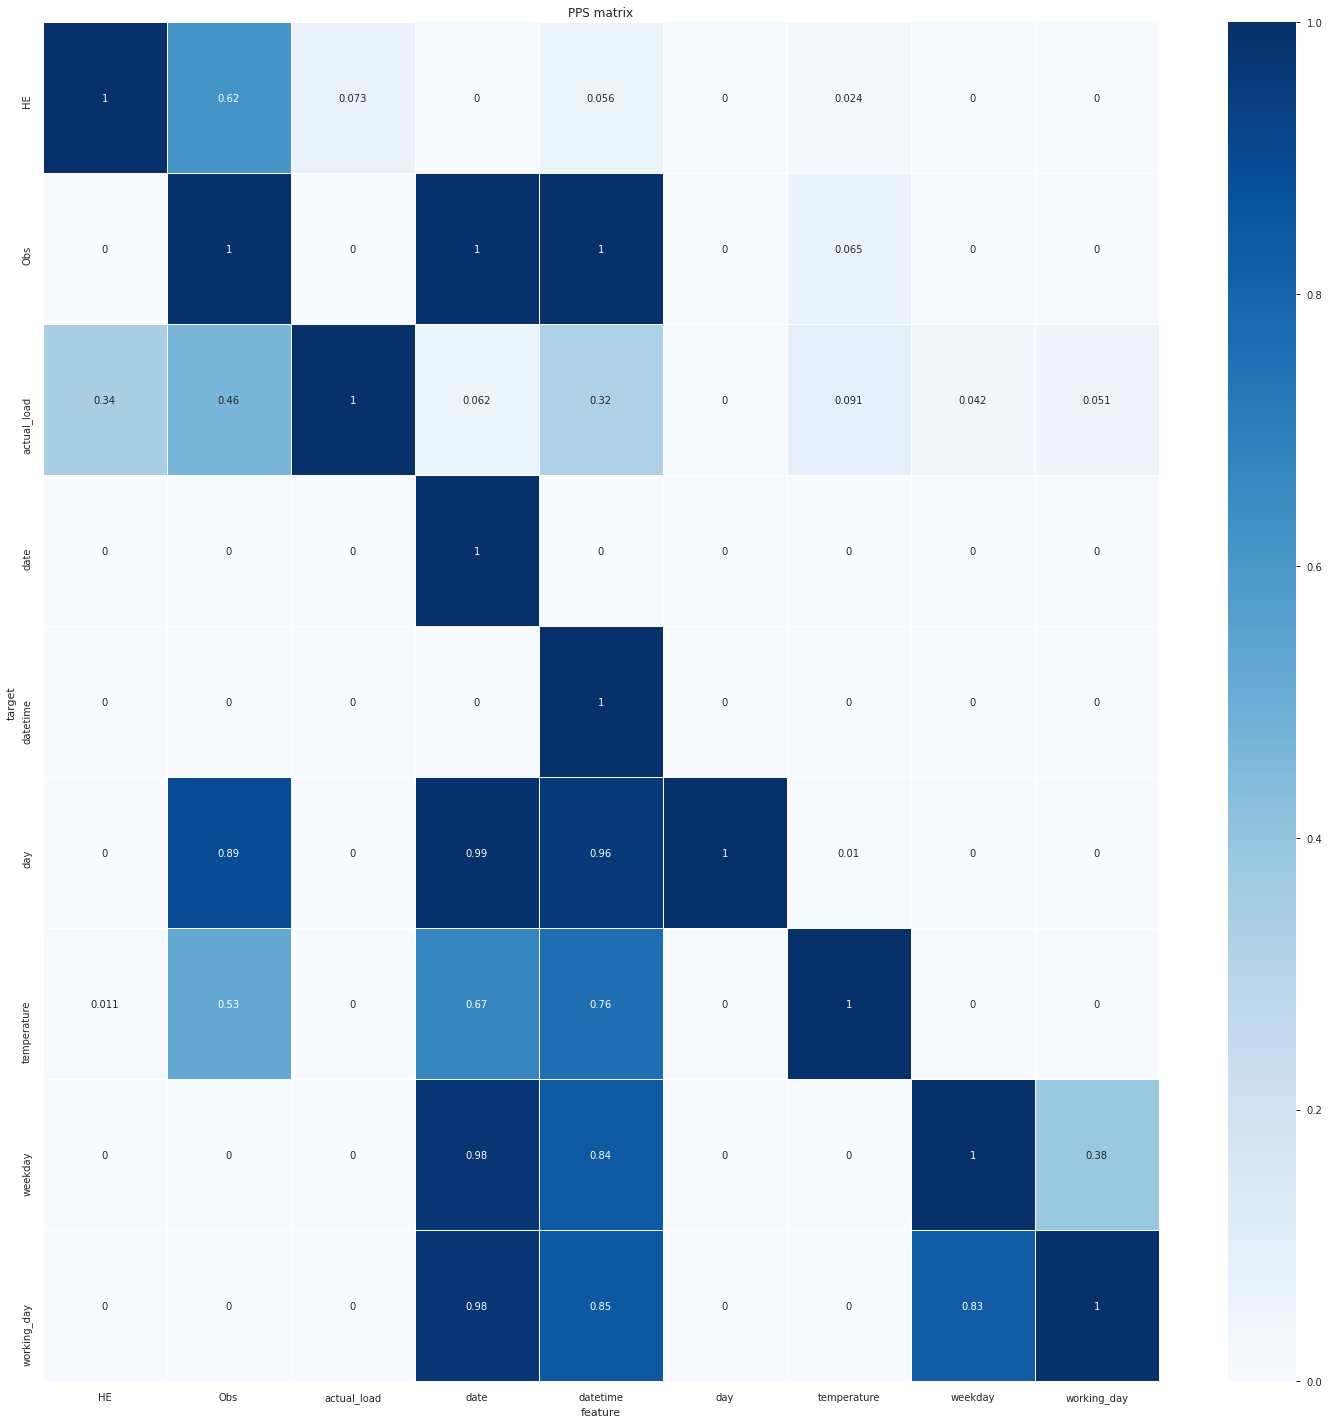

In [15]:
def heatmap(df):
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(25,25)) 
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
    ax.set_title("PPS matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    return ax

import ppscore as pps
matrix = pps.matrix(df)
heatmap(matrix)

Predictive Power Score Mаtrix показывает корреляцию между фичами. В отличие от обычной матрицы корреляций, показывающей только линейные взаимосвязи, эта матрица показывает любые взаимосвязи. Здесь видно, что такие фичи как час наблюдений, дата и время, номер наблюдений больше всего влияют на предсказываемую величину. Есть также и небольшая предсказывающая способность и у температуры. 

In [16]:
#сохранение файла для дальнейшей работы в другом ноутбуке
df.to_csv('kyiv_energo.csv')